In [256]:
import os
import timeit
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk import ngrams, FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, TfidfTransformer

In [2]:
no_real_disater = 0
real_disaster = 1

no_real_disaster_label = "no_real_disaster"
real_disaster_label = "real_disaster"

target_names = ["Not real disaster", "Real disaster"]

target_dict = {
    "label": target_names,
    "value": [0, 1]
}
target_df = pd.DataFrame(target_dict)

original_columns = ["id", "keyword", "location", "text", "target"]

stop_words = stopwords.words('english')

### Data folders

In [3]:
data_folder = "data"
submissions_folder = os.path.join(data_folder, "submissions") 

train_file = os.path.join(data_folder, "train.csv")
test_file = os.path.join(data_folder, "test.csv")

### Data analysis

In [4]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)


# Adding target labels
train_df.loc[:, "target_str"] = pd.merge(train_df, target_df, how="left", left_on="target", right_on="value")["label"]

train_df.head()

,id,keyword,location,text,target,target_str
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Real disaster
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Real disaster
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,Real disaster
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,Real disaster
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster


In [5]:
print(f"Train size: {train_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (7613, 6)
Test size: (3263, 4)


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          7613 non-null   int64 
 1   keyword     7552 non-null   object
 2   location    5080 non-null   object
 3   text        7613 non-null   object
 4   target      7613 non-null   int64 
 5   target_str  7613 non-null   object
dtypes: int64(2), object(4)
memory usage: 357.0+ KB


#### Convert to string type

In [7]:
string_columns = ["keyword", "location", "text", "target_str"]
train_df.loc[:, string_columns] = train_df[string_columns].astype("string")

In [8]:
train_df.head()

,id,keyword,location,text,target,target_str
0,1,<NA>,<NA>,Our Deeds are the Reason of this #earthquake M...,1,Real disaster
1,4,<NA>,<NA>,Forest fire near La Ronge Sask. Canada,1,Real disaster
2,5,<NA>,<NA>,All residents asked to 'shelter in place' are ...,1,Real disaster
3,6,<NA>,<NA>,"13,000 people receive #wildfires evacuation or...",1,Real disaster
4,7,<NA>,<NA>,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster


#### NaNs vs NO NaNs by column

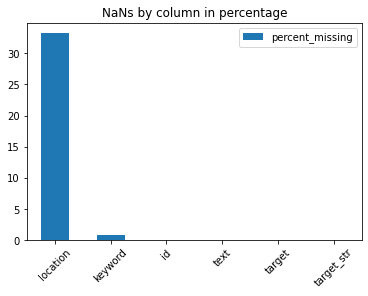

In [9]:
percent_missing = train_df.isnull().sum() * 100 / train_df.shape[0]
missing_value_df = pd.DataFrame({"percent_missing": percent_missing})

missing_value_df.sort_values(by="percent_missing", ascending=False).plot(
    kind="bar", title="NaNs by column in percentage", rot=45)

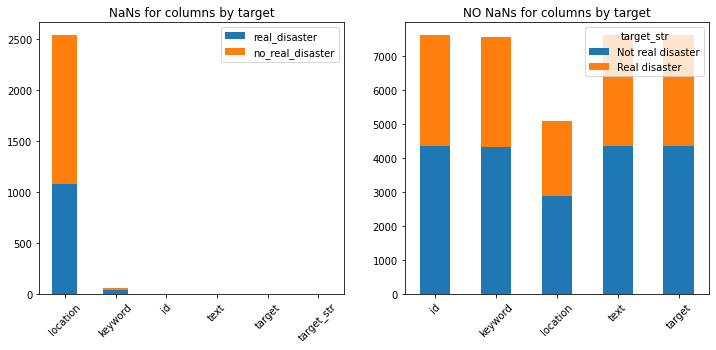

In [10]:
no_nan_df = train_df.groupby("target_str").count().transpose()

cond_disaster = train_df.target == real_disaster
nan_df = pd.concat([train_df[cond_disaster].isnull().sum(),
                    train_df[~cond_disaster].isnull().sum()], axis=1)
nan_df.columns = [real_disaster_label, no_real_disaster_label]
nan_df.sort_values(by=[real_disaster_label], ascending=False, inplace=True)

fig = plt.figure(figsize=(12, 5))

# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(121)
# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(122)

nan_df.plot(kind="bar", stacked=True, title="NaNs for columns by target", ax=ax1, rot=45)
no_nan_df.plot(kind="bar", stacked=True, title="NO NaNs for columns by target", ax=ax2, rot=45)

#### Keyword

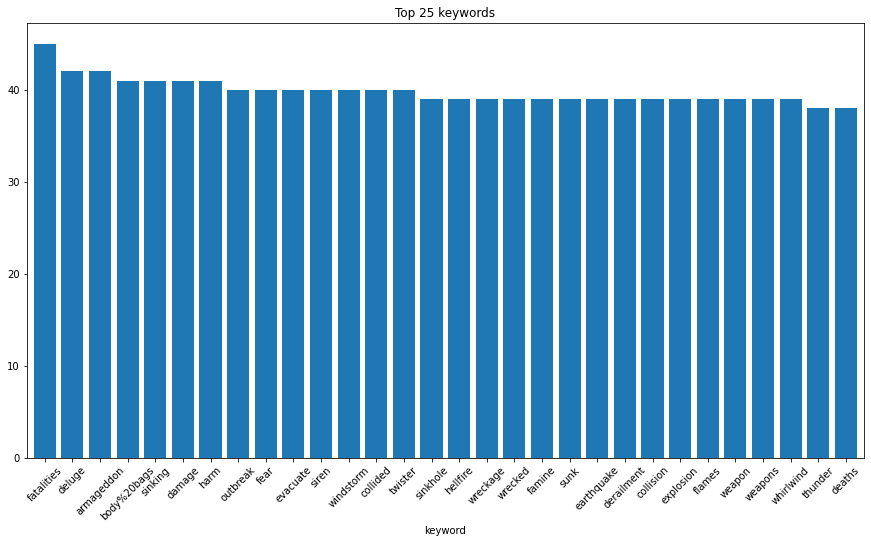

In [11]:
train_df.groupby("keyword").size().sort_values(ascending=False)[:30].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Top 25 keywords", rot=45)

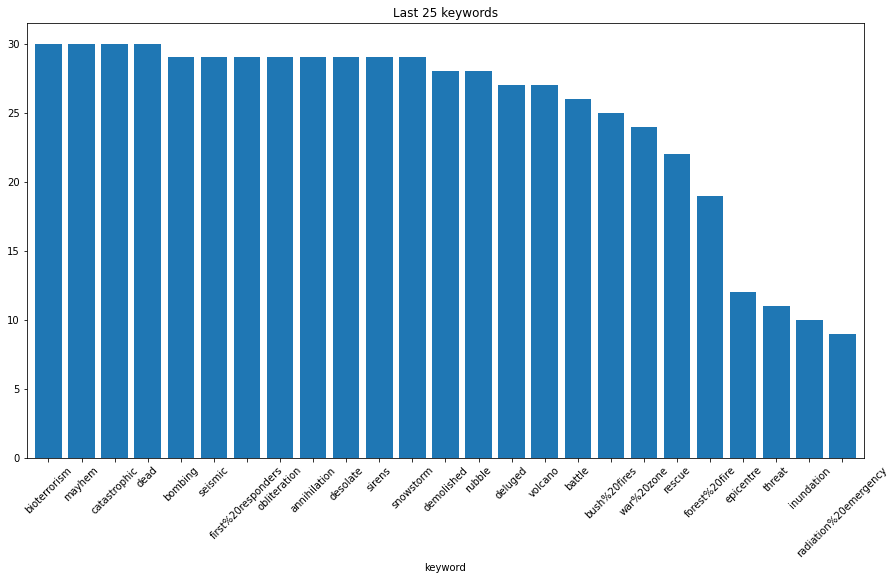

In [12]:
train_df.groupby("keyword").size().sort_values(ascending=False)[-25:].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Last 25 keywords", rot=45)

#### Location

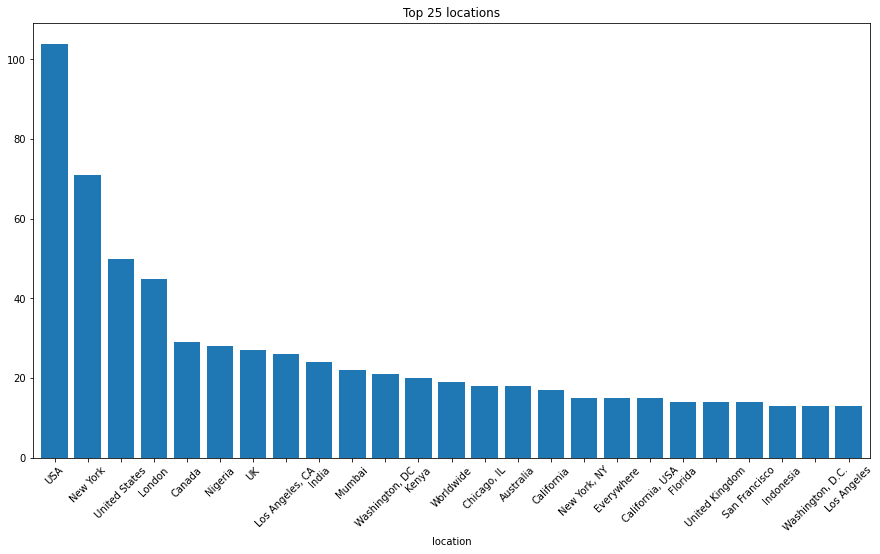

In [13]:
train_df.groupby("location").size().sort_values(ascending=False)[:25].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Top 25 locations", rot=45)

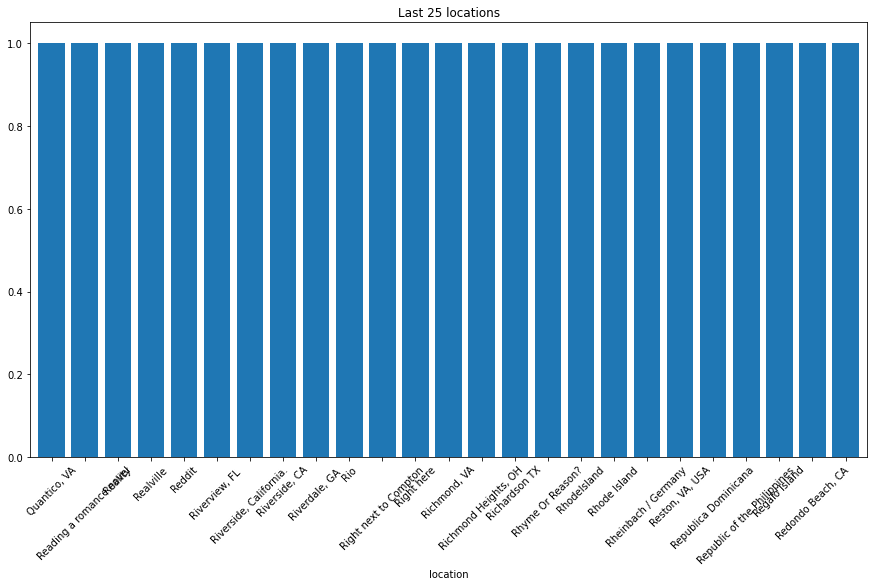

In [14]:
train_df.groupby("location").size().sort_values(ascending=False)[-25:].plot(
    kind="bar", figsize=(15, 8), width=0.8, title="Last 25 locations", rot=45)

#### Target

(-1.25, 1.25, -1.25, 1.25)

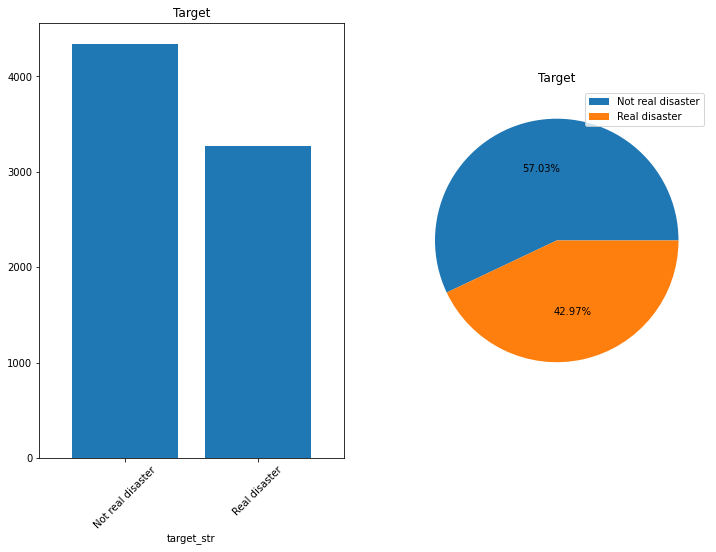

In [15]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

train_df.groupby("target_str").size().sort_values(ascending=False).plot(
    kind="bar", width=0.8, title="Target", ax=ax1, rot=45)

train_df.groupby("target_str").size().sort_values(ascending=False).plot(
    kind="pie", title="Target", ax=ax2, legend=True, autopct="%.2f%%", labels=None)

ax2.axis("off")

### Text

Choose randomly 5 tweets for visualize text content

In [16]:
for tweet, keyword, label in train_df[["text", "keyword", "target_str"]].sample(n=5).values:
    print(f"{keyword}\n{tweet}\n{label}\n")

refugees
...//..// whao.. 12000 Nigerian refugees repatriated from Cameroon http://t.co/baE0Ap4G9Y
Real disaster

survivors
Dear @POTUS In the name of humanityI apologized to #Hiroshima Survivors.R u ready to do so?#Japan #nuclearweapons http://t.co/TWykzN4rlC
Real disaster

collapse
åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Tent Collapse Story: Correction: Tent Collapse story åÈ http://t.co/fDJUYvZMrv @wizkidayo
Not real disaster

burned
@thomasvissman22 @KeithyyL Keithyy gettin burned outta the blocks and on social media.... http://t.co/dlkuFtLQnF
Not real disaster

lightning
Wolforth with a two-out single up the middle. Fourth hit of the night for Altamonte Springs.
Not real disaster



In [17]:
# Adding new feature: text_lenght
train_df.loc[:, "text_lenght"] = train_df.text.str.len()

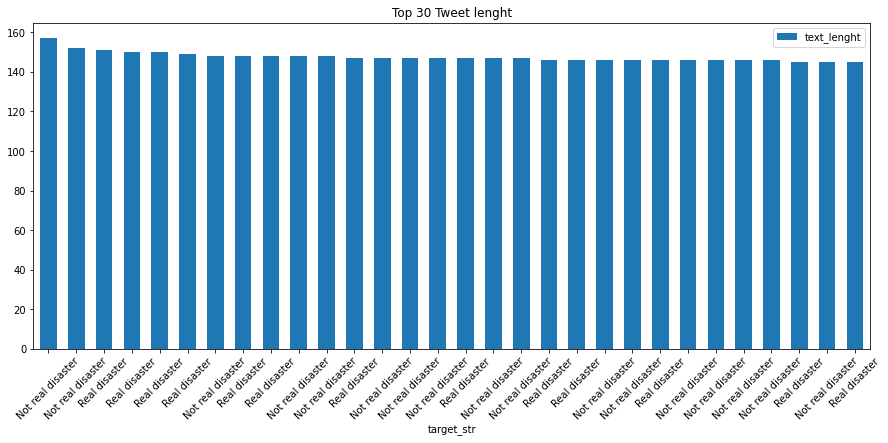

In [18]:
top_len_df = train_df[["text_lenght", "target", "target_str"]].sort_values(
    by="text_lenght", ascending=False).head(30).reset_index(drop=True)
last_len_df = train_df[["text_lenght", "target", "target_str"]].sort_values(
    by="text_lenght", ascending=False).tail(30).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(15, 6))
top_len_df.plot(kind="bar", y="text_lenght", x="target_str", width=0.6, 
                ax=ax, title="Top 30 Tweet lenght", rot=45)

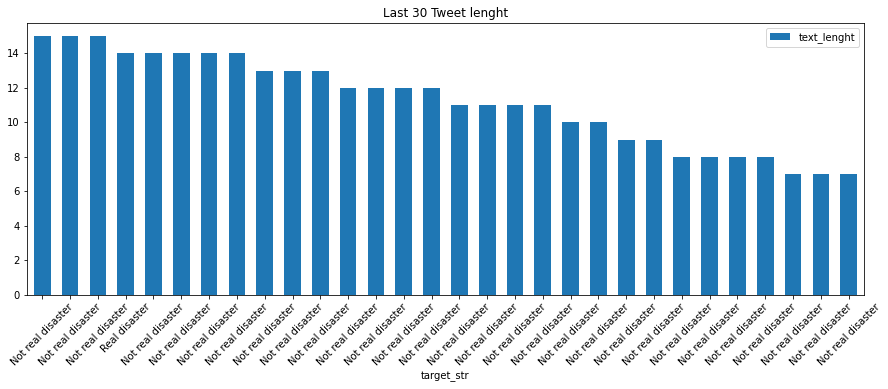

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))
last_len_df.plot(kind="bar", y="text_lenght", x="target_str", width=0.6, 
                ax=ax, title="Last 30 Tweet lenght", rot=45)

In [20]:
def generate_word_frequences_dict(text_list, stop_words):
    # Filter stop words and remove puntuation
    word_list = [word for text in text_list for word in text if word.isalpha() and word not in stop_words]
    return pd.Series(word_list).value_counts().to_dict()

def generate_word_cloud(text_list, title, stop_words=stop_words):
    frequences_dict = generate_word_frequences_dict(text_list, stop_words)
    # Create and generate a word cloud image:
    wordcloud = WordCloud().generate_from_frequencies(frequences_dict)

    fig = plt.subplots(figsize=(20, 12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=32)
    plt.show()

In [21]:
def split_text(text, stop_words):
    # Split text into tokens
    tokens = word_tokenize(text)
    # Remove puntuations
    words = [word for word in tokens if word.isalpha()]
    # Filter stop words
    words = [word for word in words if word not in stop_words]
    
    return words

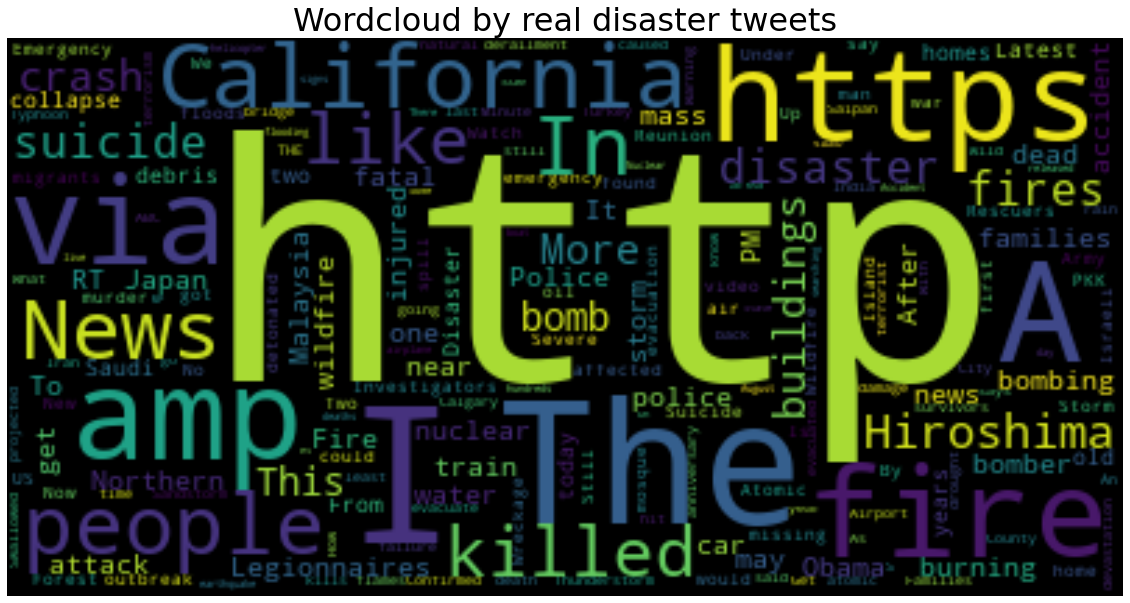

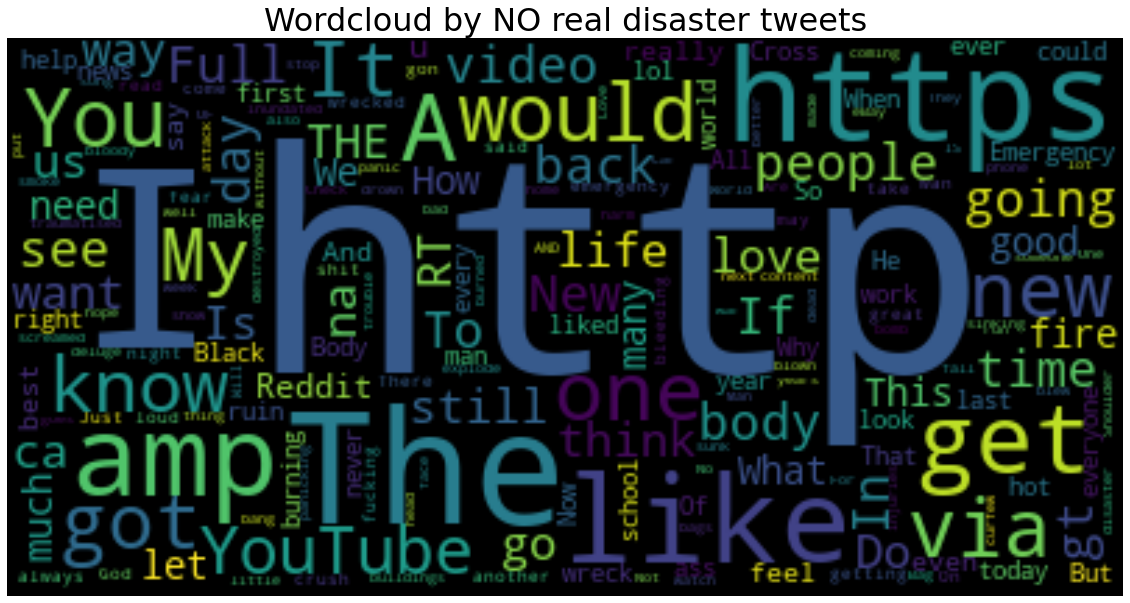

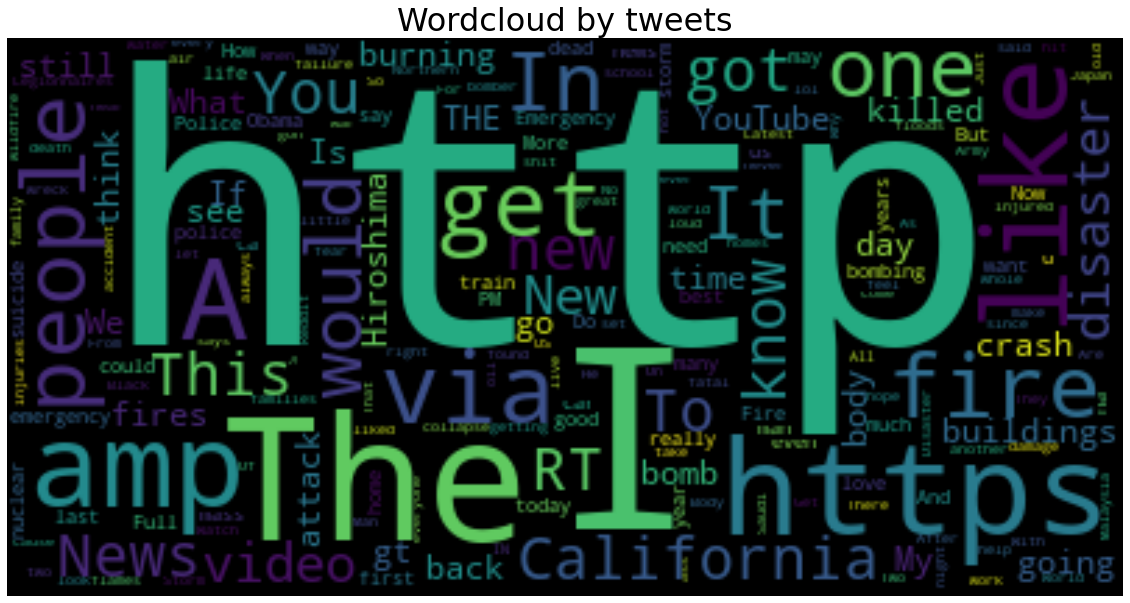

In [22]:
train_df.loc[:, "splited_text"] = train_df["text"].apply(split_text, args=(stop_words,))

generate_word_cloud(train_df[cond_disaster]["splited_text"].values.tolist(), "Wordcloud by real disaster tweets")
generate_word_cloud(train_df[~cond_disaster]["splited_text"].values.tolist(), "Wordcloud by NO real disaster tweets")
generate_word_cloud(train_df["splited_text"].values.tolist(), "Wordcloud by tweets")

### Data cleaning and feature engineering

Remove id column because is not useful

In [23]:
train_df.drop("id", axis=1, inplace=True)

In [24]:
train_df.head()

,keyword,location,text,target,target_str,text_lenght,splited_text
0,<NA>,<NA>,Our Deeds are the Reason of this #earthquake M...,1,Real disaster,69,"[Our, Deeds, Reason, earthquake, May, ALLAH, F..."
1,<NA>,<NA>,Forest fire near La Ronge Sask. Canada,1,Real disaster,38,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,<NA>,<NA>,All residents asked to 'shelter in place' are ...,1,Real disaster,133,"[All, residents, asked, place, notified, offic..."
3,<NA>,<NA>,"13,000 people receive #wildfires evacuation or...",1,Real disaster,65,"[people, receive, wildfires, evacuation, order..."
4,<NA>,<NA>,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster,88,"[Just, got, sent, photo, Ruby, Alaska, smoke, ..."


Replace NaN values from keyword and location columns by empty string ("")

In [25]:
train_df.loc[:, ["keyword", "location"]] = train_df[["keyword", "location"]].fillna("")

Create new features based on keyword and location (and previous text_lenght).

In [27]:
train_df.loc[:, "with_keyword"] = train_df.keyword.str.len().astype(bool)
train_df.loc[:, "with_location"] = train_df.location.str.len().astype(bool)

train_df.head()

,keyword,location,text,target,target_str,text_lenght,splited_text,with_keyword,with_location
0,,,Our Deeds are the Reason of this #earthquake M...,1,Real disaster,69,"[Our, Deeds, Reason, earthquake, May, ALLAH, F...",False,False
1,,,Forest fire near La Ronge Sask. Canada,1,Real disaster,38,"[Forest, fire, near, La, Ronge, Sask, Canada]",False,False
2,,,All residents asked to 'shelter in place' are ...,1,Real disaster,133,"[All, residents, asked, place, notified, offic...",False,False
3,,,"13,000 people receive #wildfires evacuation or...",1,Real disaster,65,"[people, receive, wildfires, evacuation, order...",False,False
4,,,Just got sent this photo from Ruby #Alaska as ...,1,Real disaster,88,"[Just, got, sent, photo, Ruby, Alaska, smoke, ...",False,False


### Clean tweets content

- Remove puntiation
- Filter stop words
- Stemming

NLTK data url: https://github.com/nltk/nltk_data

Convert tweets to sentences

In [28]:
def text_cleaning(text, stop_words=stop_words):
    # Split text into tokens
    tokens = word_tokenize(text)
    # Remove puntuations
    words = [word for word in tokens if word.isalpha()]
    # Filter stop words
    words = [word for word in words if word not in stop_words]
    # Stemming
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    
    return stemmed

In [29]:
train_df.loc[:, "splitted_cleaned_text"] = train_df["text"].apply(text_cleaning, args=(stop_words,))

Choose randomly 5 tweets for visualize text and list of cleaned words

In [30]:
for tweet, cleaned, label in train_df[["text", "splitted_cleaned_text", "target_str"]].sample(n=5).values:
    print(f"{tweet}\n{cleaned}\n{label}\n")

Salem 2 nuclear reactor shut down over electrical circuit failure on pump: The Salem 2 nuclear reactor had bee... http://t.co/5hkGXzJLmX
['salem', 'nuclear', 'reactor', 'shut', 'electr', 'circuit', 'failur', 'pump', 'the', 'salem', 'nuclear', 'reactor', 'bee', 'http']
Real disaster

It's lights out again with stage-two load shedding: Stage-two load shedding will be in force between 5pm and 10pm. http://t.co/vxVfAEEY0q
['It', 'light', 'load', 'shed', 'load', 'shed', 'forc', 'http']
Not real disaster

Bradford. Back to doing what we do best. Burning down our own buildings. Read it and weep Leeds. https://t.co/OLnfzb86zb
['bradford', 'back', 'best', 'burn', 'build', 'read', 'weep', 'leed', 'http']
Real disaster

The girl that I wanna save is like a danger to my health try being with somebody that wanna be somebody else.
['the', 'girl', 'I', 'wan', 'na', 'save', 'like', 'danger', 'health', 'tri', 'somebodi', 'wan', 'na', 'somebodi', 'els']
Not real disaster

//im gonna beat armageddon as H

### Vectoritzation I: Count vectorizer

In [131]:
example_sentences = [
    'He is playing in the field field',
    'He is running towards the football',
    'The football game ended',
    'It started raining while everyone was playing in the field'
]

words = list()
for sentence in example_sentences:
    for word in sentence.split(" "):
        words.append(word)
        
word_number = collections.Counter(words)

print(f"Top 5 words: {word_number.most_common(5)}")

Top 5 words: [('the', 3), ('field', 3), ('He', 2), ('is', 2), ('playing', 2)]


In [132]:
vectorizer = CountVectorizer()
sentence_vectors = vectorizer.fit_transform(example_sentences)

print(f"All vocabulary: {vectorizer.get_feature_names()}")

All vocabulary: ['ended', 'everyone', 'field', 'football', 'game', 'he', 'in', 'is', 'it', 'playing', 'raining', 'running', 'started', 'the', 'towards', 'was', 'while']


In [133]:
count_vectorized_df = pd.DataFrame(sentence_vectors.toarray(), columns=vectorizer.get_feature_names())
count_vectorized_df

,ended,everyone,field,football,game,he,in,is,it,playing,raining,running,started,the,towards,was,while
0,0,0,2,0,0,1,1,1,0,1,0,0,0,1,0,0,0
1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,1,0,0
2,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0,1,1,0,0,0,1,0,1,1,1,0,1,1,0,1,1


Vectoritzation of first sentence

In [134]:
non_zero_columns = count_vectorized_df.head(1)[count_vectorized_df > 0].dropna(axis=1).columns.tolist()
print(f"For sentenence 1 this columns {non_zero_columns} are greather than 0 (full sentence)")
print(example_sentences[0])
count_vectorized_df.head(1)

For sentenence 1 this columns ['field', 'he', 'in', 'is', 'playing', 'the'] are greather than 0 (full sentence)
He is playing in the field field


,ended,everyone,field,football,game,he,in,is,it,playing,raining,running,started,the,towards,was,while
0,0,0,2,0,0,1,1,1,0,1,0,0,0,1,0,0,0


In [135]:
count_vectorized_df.sum().sort_values(ascending=False)

the         4
field       3
in          2
football    2
playing     2
he          2
is          2
while       1
everyone    1
game        1
it          1
was         1
raining     1
running     1
started     1
towards     1
ended       1
dtype: int64

In [136]:
word_number.most_common(5)

[('the', 3), ('field', 3), ('He', 2), ('is', 2), ('playing', 2)]

Same order

### Vectoritzation II: TF-IDF Vectorizer (equivalent to CountVectorizer followed by TfidfTransformer)

<b>TF (Term Frequency):</b> It is defined as the number of times a word appears in the given sentence.<br>
<b>IDF (Inverse Document Frequency):</b> It is defined as the log to the base e of number of the total documents divided by the documents in which the word appears.

In [90]:
vectorizer = TfidfVectorizer()
sentence_vectors = vectorizer.fit_transform(example_sentences)

print(f"All vocabulary {vectorizer.get_feature_names()}")

All vocabulary ['ended', 'everyone', 'field', 'football', 'game', 'he', 'in', 'is', 'it', 'playing', 'raining', 'running', 'started', 'the', 'this', 'towards', 'was', 'while']


In [91]:
tf_idf_vectorized_df = pd.DataFrame(sentence_vectors.toarray(), columns=vectorizer.get_feature_names())
tf_idf_vectorized_df

,ended,everyone,field,football,game,he,in,is,it,playing,raining,running,started,the,this,towards,was,while
0,0.000000,0.000000,0.553703,0.000000,0.000000,0.276851,0.553703,0.276851,0.000000,0.276851,0.000000,0.000000,0.000000,0.183245,0.351151,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.387619,0.000000,0.387619,0.000000,0.387619,0.000000,0.000000,0.000000,0.491646,0.000000,0.256561,0.000000,0.491646,0.000000,0.000000
2,0.587838,0.000000,0.000000,0.463458,0.587838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.306758,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.350562,0.276387,0.000000,0.000000,0.000000,0.276387,0.000000,0.350562,0.276387,0.350562,0.000000,0.350562,0.182938,0.000000,0.000000,0.350562,0.350562


Find words weight

In [138]:
tf_idf_vectorized_df.sum().sort_values(ascending=False)

the         0.929502
football    0.851077
field       0.830090
in          0.830090
is          0.664471
he          0.664471
ended       0.587838
game        0.587838
playing     0.553239
towards     0.491646
running     0.491646
this        0.351151
everyone    0.350562
while       0.350562
was         0.350562
raining     0.350562
started     0.350562
it          0.350562
dtype: float64

In [139]:
word_number.most_common(5)

[('the', 3), ('field', 3), ('He', 2), ('is', 2), ('playing', 2)]

In this case we can see the difference, the word "field" appears 2 times on sentence one and one time on sentence two, but have 
the same weight of "in", but "in" appears 2 times on 2 different sentences.

### Vectoritzation III: Hashing vectorizer

In [142]:
vectorizer = HashingVectorizer(norm=None, n_features=5)
sentence_vectors = vectorizer.fit_transform(example_sentences)

print(sentence_vectors.toarray())

[[-2.  0.  2. -1.  2.]
 [ 0. -1.  3. -1.  1.]
 [ 0. -1.  1. -2.  0.]
 [-3.  1.  1.  0. -1.]]


In [ ]:
# Provar el tf-idf amb stop words i svm

In [150]:
pipeline = Pipeline([
    ("bow", CountVectorizer(analyzer=text_cleaning)),  # strings to token integer counts
    ("tfidf", TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ("classifier", MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

### Model Validation

Try different experiments to evaluate different models

In [144]:
x_train, x_test, y_train, y_test = train_test_split(train_df["text"], train_df["target"], test_size=0.20)

In [245]:
def train_and_predict_pipeline(pipeline, x_train, y_train, x_test, y_test, target_names):
    print("\nTraining model ...")
    
    start = timeit.default_timer()
    pipeline.fit(x_train, y_train)
    stop = timeit.default_timer()
    
    training_time = stop - start
    print(f"Done!\nTraining time: {training_time}\nMaking predictions...")
    
    y_pred = pipeline.predict(x_test)
    
    accuracy = accuracy_score(y_pred, y_test)
    
    print(classification_report(y_pred, y_test, target_names=target_names))
    print(f"Confusion matrix:\n{confusion_matrix(y_pred, y_test)}")
    print(f"\nAccuracy: {accuracy}")
    print("-"*20)
    
    return training_time, accuracy

In [246]:
pipelines = list()

pipeline_bayes = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer=text_cleaning)),
    ("classifier", MultinomialNB())
])
pipelines.append(("NaiviBayes", pipeline_bayes))

pipeline_logistic = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer=text_cleaning)),
    ("classifier", LogisticRegression())
])
pipelines.append(("Logistic Regression", pipeline_logistic))

pipeline_ridge = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer=text_cleaning)),
    ("classifier", RidgeClassifier())
])
pipelines.append(("Ridge", pipeline_ridge))

pipeline_svm = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer=text_cleaning)),
    ("classifier", SVC())
])
pipelines.append(("SVM", pipeline_svm))

pipeline_random_forest = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer=text_cleaning)),
    ("classifier", RandomForestClassifier(n_estimators=75))
])
pipelines.append(("Random Forest", pipeline_random_forest))

results = collections.defaultdict(list)

for model, pipe in pipelines:
    print(model)
    training_time, acc = train_and_predict_pipeline(pipe, x_train, y_train, x_test, y_test, target_names)
    
    results["model"].append(model)
    results["time"].append(training_time)
    results["accuracy"].append(acc)

results_df = pd.DataFrame(results)

NaiviBayes

Training model ...
Done!
Training time: 2.586309134001567
Making predictions...
                   precision    recall  f1-score   support

Not real disaster       0.90      0.77      0.83      1021
    Real disaster       0.63      0.82      0.71       502

         accuracy                           0.78      1523
        macro avg       0.76      0.79      0.77      1523
     weighted avg       0.81      0.78      0.79      1523

Confusion matrix:
[[782 239]
 [ 90 412]]

Accuracy: 0.7839789888378201
--------------------
Logistic Regression

Training model ...
Done!
Training time: 2.6763326410000445
Making predictions...
                   precision    recall  f1-score   support

Not real disaster       0.88      0.78      0.83       988
    Real disaster       0.67      0.81      0.73       535

         accuracy                           0.79      1523
        macro avg       0.78      0.80      0.78      1523
     weighted avg       0.81      0.79      0.79      1523



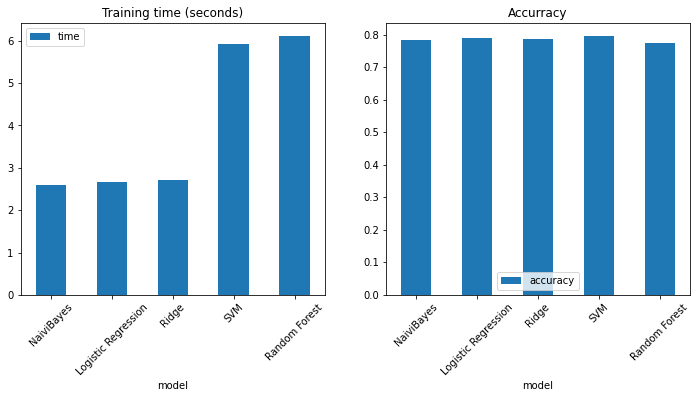

In [255]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

results_df[["model", "time"]].plot(kind="bar", x="model", y="time", rot=45, title="Training time (seconds)", ax=ax1)
results_df[["model", "accuracy"]].plot(kind="bar", x="model", y="accuracy", rot=45, title="Accurracy", ax=ax2)

### Use Grid Search for find the best model parameters

In [ ]:
# Split the dataset in two equal parts

vectorizer = TfidfVectorizer(analyzer=text_cleaning)

x = vectorizer.fit_transform(train_df["text"])
y = train_df["target"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

c_list = [0.1, 1, 10, 100, 1000, 10000]
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5, 'scale', 'auto'], 'C': c_list}]
                    # {'kernel': ['linear'], 'C': c_list},
                    # {'kernel': ['poly'], 'C': c_list, 'degree': [2, 3, 4]},
                    # {'kernel': ['sigmoid'], 'C': c_list}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print(accuracy_score(y_pred, y_test))
    print()

# Tuning hyper-parameters for precision



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [294]:
x_train, x_test, y_train, y_test = train_test_split(train_df["text"], train_df["target"], test_size=0.15)

pipeline_svm = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer=text_cleaning)),
    ("classifier", SVC(C=1000, gamma="scale", kernel="rbf")) # C=1000, gamma="scale", kernel="rbf"
])

_ = train_and_predict_pipeline(pipeline_svm, x_train, y_train, x_test, y_test, target_names)


Training model ...
Done!
Training time: 5.910265284999696
Making predictions...
                   precision    recall  f1-score   support

Not real disaster       1.00      0.59      0.75      1076
    Real disaster       0.13      1.00      0.23        66

         accuracy                           0.62      1142
        macro avg       0.57      0.80      0.49      1142
     weighted avg       0.95      0.62      0.72      1142

Confusion matrix:
[[640 436]
 [  0  66]]

Accuracy: 0.6182136602451839
--------------------


In [283]:
pipeline_svm.fit(train_df["text"], train_df["target"])

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer=<function text_cleaning at 0x129069d30>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('classifier',
                 SVC(C=1000, break_ties=False, cache_size=200,
                     class_weight=None, coef

In [ ]:
# Try with best method to clean text
clean html code
use tweet special text processor

#### Prediction and generate kaggle submission

In [284]:
y_pred = pipeline_svm.predict(test_df["text"])

In [285]:
def create_submission_file(predictions, ids, path, filename="submission.csv"):
    submission_data = {
        "id": ids,
        "target": predictions
    }

    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(os.path.join(path, filename), index=False)
    
    print("Good luck!")

In [286]:
create_submission_file(y_pred, test_df.id, submissions_folder)

Good luck!


In [134]:
# TODO: Lemmatization